In [47]:
import numpy as np
import astropy.units as u
from astropy.io import fits

import time
import os
from pathlib import Path

import poppy

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
platform = jax.devices()[0].platform
device = jax.devices()[0].device_kind

print(f'Jax platform: {platform}')
print(f'Jax device: {device}')

import utils
import imshows
from imshows import *

wavelength = 633*u.nm
pupil_diam = 10*u.mm
fl = 200*u.mm
fnum = fl.to_value(u.mm)/pupil_diam.to_value(u.mm)

# bw = 0.1
# nwaves = 5
# wavelengths = jnp.linspace(wavelength-wavelength*bw/2.0, wavelength+wavelength*bw/2.0, num=nwaves)
# spectrum = jnp.linspace(1, 2, num=nwaves)

npix = 200
oversample = 4
N = int(npix*oversample)
nim = 200

pixelscale_lamD = 1/oversample
um_per_lamD = wavelength.to(u.um) * fnum
pixelscale_m = pixelscale_lamD * um_per_lamD.to_value(u.m)
print(pixelscale_lamD, pixelscale_m)

def pad_or_crop( arr_in, npix ):
    n_arr_in = arr_in.shape[0]
    if n_arr_in == npix:
        return arr_in
    elif npix < n_arr_in:
        x1 = n_arr_in // 2 - npix // 2
        x2 = x1 + npix
        arr_out = arr_in[x1:x2,x1:x2]
    else:
        arr_out = jnp.zeros((npix,npix), dtype=arr_in.dtype)
        x1 = npix // 2 - n_arr_in // 2
        x2 = x1 + n_arr_in
        arr_out = arr_out.at[x1:x2,x1:x2].set(arr_in)
    return arr_out

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe
0.25 3.1649999999999998e-06


In [2]:
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1)
ap = poppy.NgonAperture(nsides=12, radius=pupil_diam/2).get_transmission(wf)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


In [36]:
utils.save_fits(f'aperture_{npix:d}.fits', ap.get())

Saved data to:  aperture_200.fits


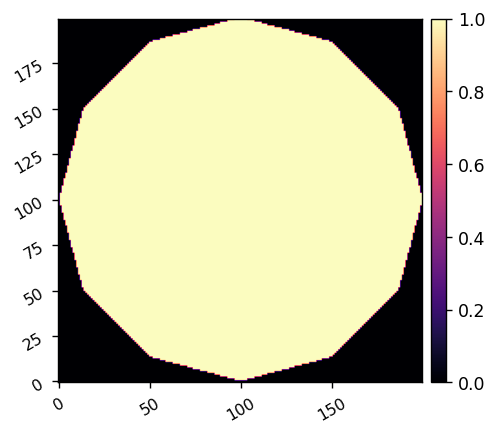

In [3]:
ap = jnp.asarray(fits.getdata(f'aperture_{npix:d}.fits'))
imshow1(ap)

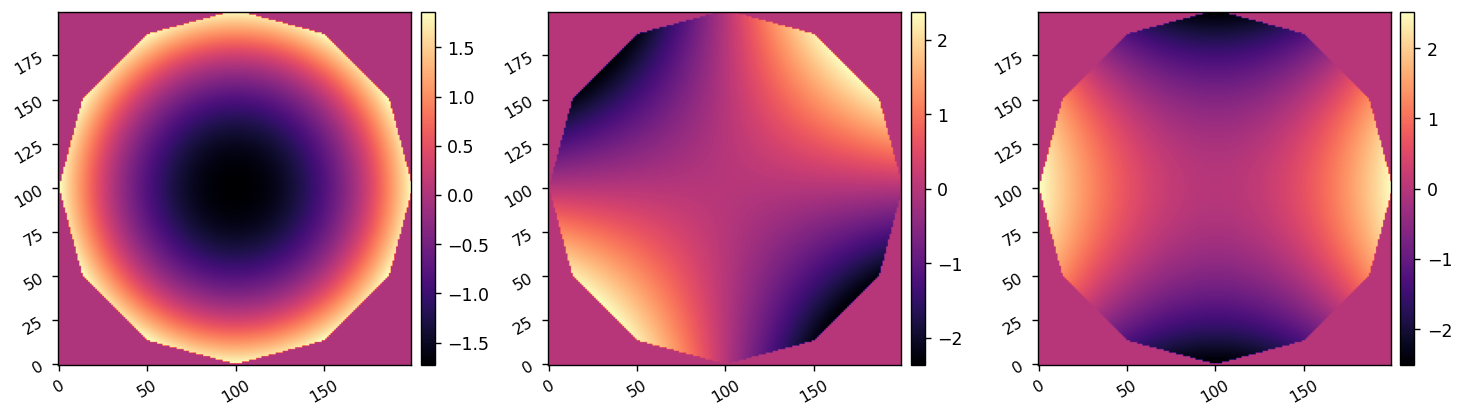

In [128]:
nmodes = 25
zmodes = poppy.zernike.arbitrary_basis(ap, nterms=nmodes+3, outside=0)[3:]
modes = zmodes.reshape(nmodes, npix**2).T
imshow3(zmodes[0], zmodes[1], zmodes[2])

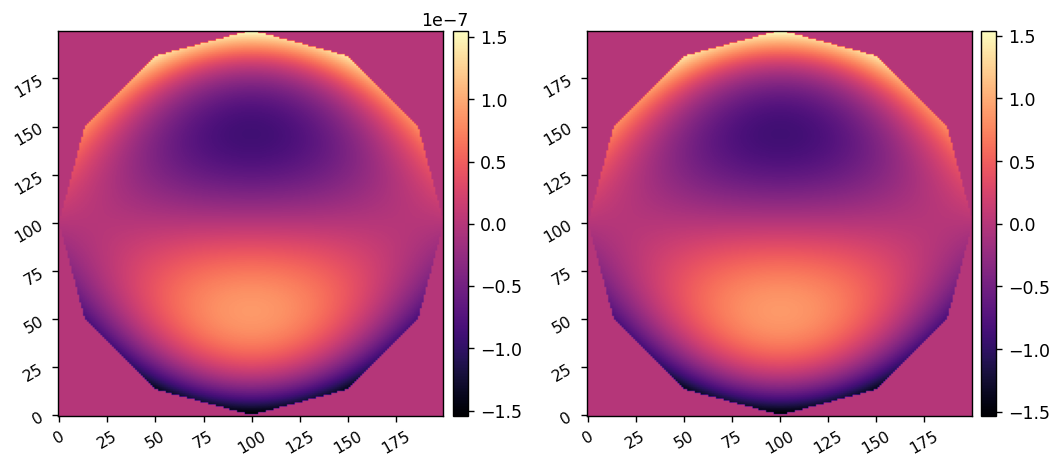

In [133]:
np.random.seed(123)
a = 3e-9 * np.random.randn(nmodes)
a[0] = 0 # just set the defocus coefficient to 0
a = np.zeros(nmodes)
a[3] = 50e-9
wfe = modes.get().dot(a).reshape(npix,npix)
pupil = ap*jnp.exp(1j*2*np.pi*wfe/wavelength.to_value(u.m))
imshow2(wfe, np.asarray(jnp.angle(pupil)))

In [134]:
def interp_arr(arr, pixelscale, new_pixelscale, order=1):
        Nold = arr.shape[0]
        old_xmax = pixelscale * Nold/2

        x,y = jnp.ogrid[-old_xmax:old_xmax-pixelscale:Nold*1j,
                        -old_xmax:old_xmax-pixelscale:Nold*1j]

        Nnew = int(np.ceil(2*old_xmax/new_pixelscale)) - 1
        new_xmax = new_pixelscale * Nnew/2

        newx,newy = jnp.mgrid[-new_xmax:new_xmax-new_pixelscale:Nnew*1j,
                              -new_xmax:new_xmax-new_pixelscale:Nnew*1j]

        x0 = x[0,0]
        y0 = y[0,0]
        dx = x[1,0] - x0
        dy = y[0,1] - y0

        ivals = (newx - x0)/dx
        jvals = (newy - y0)/dy

        coords = jnp.array([ivals, jvals])

        interped_arr = jax.scipy.ndimage.map_coordinates(arr, coords, order=order)
        return interped_arr

def forward_model(pupil, pixelscale_lamD=None, npsf=None, norm_factor=None):
    pupil = pad_or_crop(pupil, N)
    image = jnp.abs(jnp.fft.ifftshift(jnp.fft.fft2(jnp.fft.fftshift(pupil))))**2
    if pixelscale_lamD is not None:
        image = interp_arr(image, (1/oversample), pixelscale_lamD)
    if npsf is not None: 
         image = pad_or_crop(image, npsf)
    # image /= norm_factor
    return image

In [135]:
image = forward_model(pupil, npsf=nim)
# image = forward_model(ap, npsf=nim)

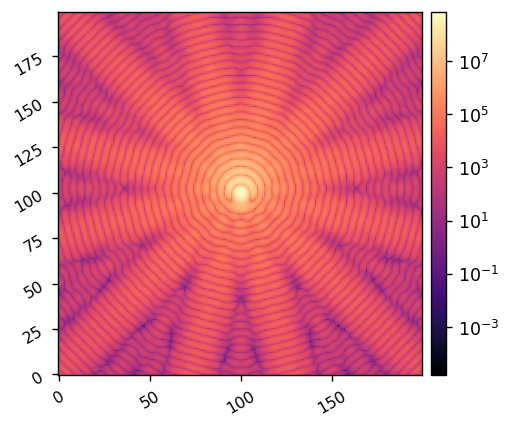

In [136]:
imshow1(image, lognorm=True)

In [137]:
long_def = 0.5*u.mm
Wd = long_def * pupil_diam**2 / (8* fl**2)
Wd = long_def/(8*fnum**2)
Wd.to(u.nm)

<Quantity 156.25 nm>

In [138]:

defocus = np.array([-200, -50, 100, 300]) * u.nm
long_defocus = 8*fnum**2*defocus.to_value(u.m)
Ndef = len(defocus)
print(long_defocus*1000)

images = []
for i in range(Ndef):
    a[0] = defocus[i].to_value(u.m)
    wfe = modes.get().dot(a).reshape(npix,npix)
    pupil = ap*jnp.exp(1j*2*np.pi*wfe/wavelength.to_value(u.m))
    image = forward_model(pupil, npsf=nim)
    images.append(image)
images= jnp.array(images)

[-0.64 -0.16  0.32  0.96]


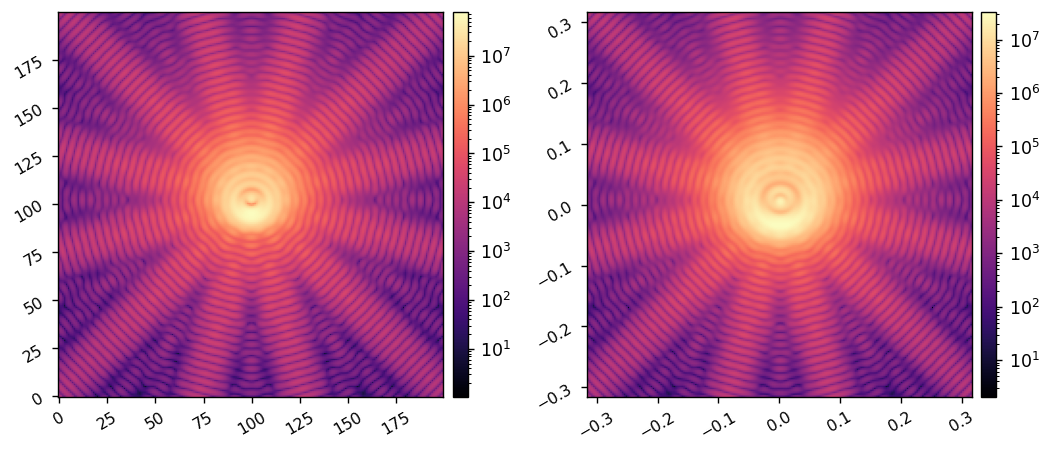

In [139]:
imshow2(images[0], images[3], lognorm=True, pxscl2=pixelscale_m*1000)

# Do the estimation

In [18]:
import estimation
import model

In [140]:
wavelengths = jnp.array([wavelength.to_value(u.m)])
spectrum = jnp.linspace(1, 1, num=1)

In [143]:
mod = model.ForwardModel(npix, nim, fnum, pixelscale_m, 
                           wavelength.to_value(u.m), wavelengths, 
                           long_defocus, 
                        #    spectrum=spectrum, 
                           )

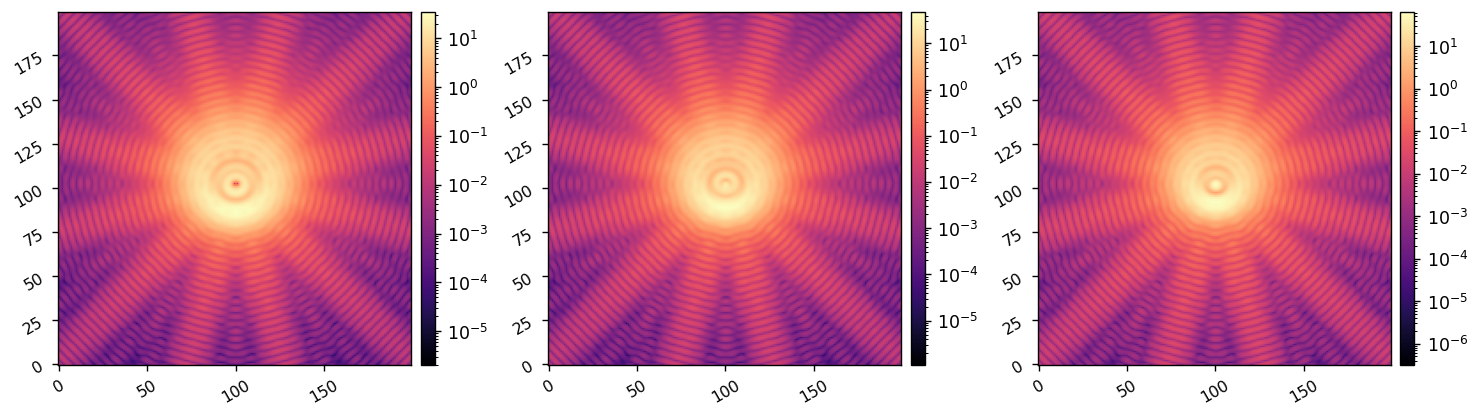

In [144]:
psfs = model.forward_propagate(ap, wfe, mod.wavelengths, mod.fresnel_TFs, mod.Mx, mod.My)
imshow3(psfs[0], psfs[1], psfs[2], lognorm=True)

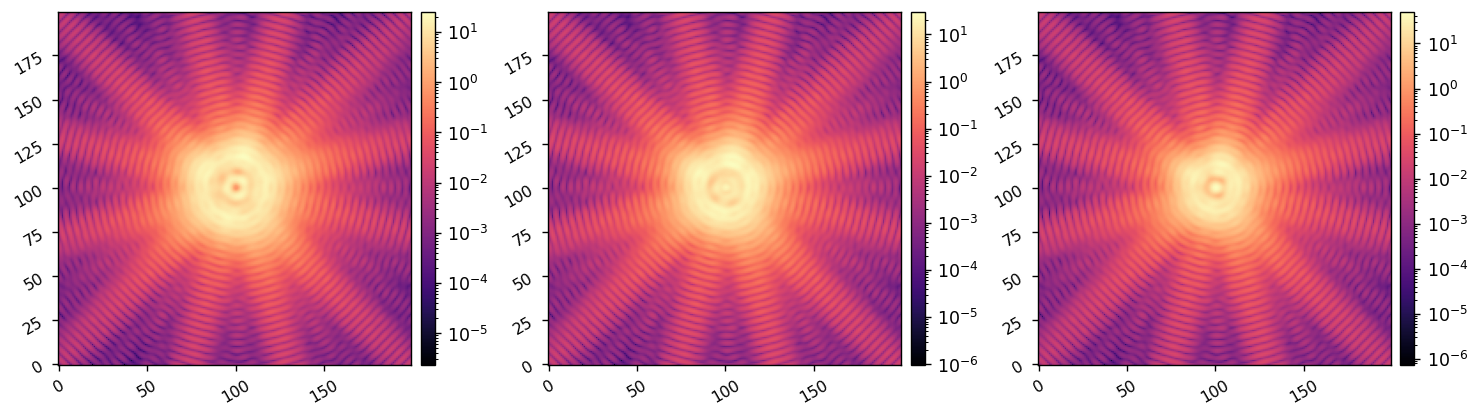

In [126]:
psfs = model.forward_propagate(ap, opd_est, mod.wavelengths, mod.fresnel_TFs, mod.Mx, mod.My)
imshow3(psfs[0], psfs[1], psfs[2], lognorm=True)

In [158]:
estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=100, wreg=1e-10)

In [27]:
estimator = estimation.Estimation(mod, estimate_phase=True, estimate_amplitude=True, maxiter=100, wreg=1e-2)

In [159]:
fit, err, objvals = estimator.run(psfs, ap)

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 6.106919053818323e-28 Stepsize:1.0  Decrease Error:0.0  Curvature Error:6.106919053818323e-28 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 1.6000774165665218e-26 Stepsize:0.5  Decrease Error:0.0  Curvature Error:1.6000774165665218e-26 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 2.759422685290578e-27 Stepsize:0.75  Decrease Error:0.0  Curvature Error:2.759422685290578e-27 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 1.2472332043693159e-27 Stepsize:0.875  Decrease Error:0.0  Curvature Error:1.2472332043693159e-27 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 7.399388699576959e-28 Stepsize:0.9375  Decrease Error:0.0  Curvature Error:7.399388699576959e-28 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decrease & Curvature Errors (s

2024-04-18 11:27:50.012245: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 4.379274728777498e-15 Stepsize:1.0  Decrease Error:0.0  Curvature Error:4.379274728777498e-15 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 4.394709292012242e-15 Stepsize:1.0  Decrease Error:0.0  Curvature Error:4.394709292012242e-15 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 4.409154413929186e-15 Stepsize:1.0  Decrease Error:0.0  Curvature Error:4.409154413929186e-15 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 4.422689681081929e-15 Stepsize:1.0  Decrease Error:0.0  Curvature Error:4.422689681081929e-15 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 4.4353881534543935e-15 Stepsize:1.0  Decrease Error:0.0  Curvature Error:4.4353881534543935e-15 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. cri

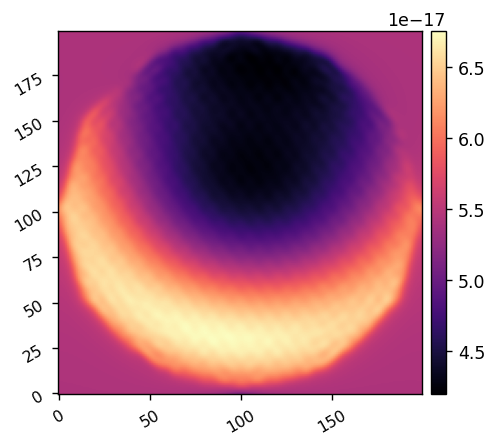

In [160]:
opd_est = fit[-1].reshape((npix,npix))
# opd_est = fit[-1,:npix*npix].reshape((npix,npix)) * ap * 1e-6


imshow1(opd_est, )

Text(0, 0.5, 'objective function value')

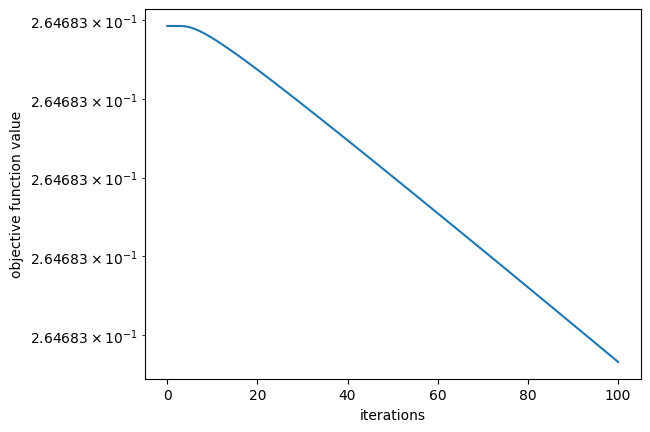

In [161]:
plt.semilogy(objvals)
plt.xlabel('iterations')
plt.ylabel('objective function value')